# BlueTrails AI - Water Quality Prediction (External Model)

**Objective**: Build separate models for 5 water quality parameters using **ONLY external data** (Open Meteo)

**Target Parameters:**
1. CHL_A (Chlorophyll A)
2. Turbidity
3. DO_mg_l (Dissolved Oxygen)
4. N_TOTAL (Total Nitrogen)
5. Temperature

**Features**: Open Meteo data (weather, marine, flood)

**Approach**: 
- Get EPA data (targets) from `v_epa_measurements_wide`
- Get Open Meteo data (features) from `v_om_measurements_wide`
- Match by site_id and date
- Build 5 separate models (one per parameter)
- Follow structure from `bluetrails_ai_separate_models_v2.ipynb`

## 1. Setup & Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supabase
from supabase import create_client, Client

# Set seeds
np.random.seed(34328637)
torch.manual_seed(34328637)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cpu
Device: CPU


## 2. Load Data from Supabase

In [2]:
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


### 2.1 Load EPA Data (Target Variables)

In [5]:
# Fetch EPA data (targets)
print("Loading EPA water quality data (targets)...")
response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_epa = pd.DataFrame(response.data)

# Filter to surface measurements only
df_epa = df_epa[df_epa['measurement_type'] == 'surface'].copy()
df_epa['date'] = pd.to_datetime(df_epa['date'])

# Create temperature column (combine temp_sensor and temp_lab)
df_epa['temperature'] = df_epa['temp_sensor'].fillna(df_epa['temp_lab'])

# Define target parameters
TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

print(f"Loaded {len(df_epa)} EPA surface measurements from {df_epa['site_id'].nunique()} sites")
print(f"Date range: {df_epa['date'].min()} to {df_epa['date'].max()}")
print(f"\nTarget parameter availability:")
for param in TARGET_PARAMS:
    available = df_epa[param].notna().sum()
    pct = (available / len(df_epa)) * 100
    print(f"  {param:15} - {available:5} ({pct:5.1f}%)")

df_epa.head()

Loading EPA water quality data (targets)...
Loaded 4492 EPA surface measurements from 21 sites
Date range: 1984-07-19 00:00:00 to 2025-06-20 00:00:00

Target parameter availability:
  chl_a           -  4432 ( 98.7%)
  turbidity       -  1593 ( 35.5%)
  do_mg_l         -  4250 ( 94.6%)
  n_total         -  4435 ( 98.7%)
  temperature     -  4130 ( 91.9%)


,site_id,site_name_short,water_body_name,date,measurement_type,latitude,longitude,chl_a,secchi_depth_m,turbidity,...,par,n_ammonia,n_nitrite,n_nitrate,n_nox,n_total,p_phosphate,p_total,silicate,temperature
0,1229,Central,Port Phillip Bay,2025-06-20,surface,-38.057034,144.870407,0.5,NaN,0.5044,...,567.360,5.0,1.0,6.0,7.0,150.0,46.0,60.0,150.0,12.5964
1,939,Corio,Port Phillip Bay,2025-06-20,surface,-38.076981,145.115005,1.1,NaN,0.4858,...,119.640,10.0,2.0,17.0,19.0,270.0,78.0,90.0,200.0,10.9897
2,1991,DMG (B),Port Phillip Bay,2025-06-20,surface,-37.870190,144.933807,1.1,NaN,0.8913,...,386.180,9.0,2.0,14.0,16.0,240.0,69.0,80.0,170.0,11.8728
3,1282,Dromana,Port Phillip Bay,2025-06-20,surface,-38.303406,144.991318,0.5,NaN,0.5670,...,288.590,5.0,1.0,5.0,6.0,200.0,58.0,70.0,150.0,11.5464
4,1911,Hobsons Bay,Port Phillip Bay,2025-06-20,surface,-38.100967,144.398727,0.3,NaN,0.8170,...,88.754,8.0,2.0,8.0,10.0,230.0,71.0,80.0,270.0,11.0016


### 2.2 Load Open Meteo Data (Feature Variables)

In [8]:
# Fetch Open Meteo data (features) - using filtered view to avoid timeout
print("\nLoading Open Meteo data (features)...")
print("Using v_om_measurements_wide_filtered (pre-filtered by EPA dates)")

# Query the filtered view that only includes dates matching EPA data
response = supabase.table('v_om_measurements_wide_filtered').select('*').execute()
df_om = pd.DataFrame(response.data)

# Filter to historical data only (not forecasts)
df_om = df_om[df_om['is_forecast'] == False].copy()
df_om['date'] = pd.to_datetime(df_om['date'])

print(f"Loaded {len(df_om)} Open Meteo measurements from {df_om['site_id'].nunique()} sites")
print(f"Date range: {df_om['date'].min()} to {df_om['date'].max()}")
print(f"\nOpen Meteo parameters: {df_om.shape[1] - 7} columns")  # Exclude metadata columns

df_om.head()


Loading Open Meteo data (features)...
Using v_om_measurements_wide_filtered (pre-filtered by EPA dates)
Loaded 4494 Open Meteo measurements from 21 sites
Date range: 1984-07-19 00:00:00 to 2025-06-20 00:00:00

Open Meteo parameters: 52 columns


,site_id,site_name_short,water_body_name,date,is_forecast,latitude,longitude,temperature_2m_mean,temperature_2m_max,temperature_2m_min,...,surface_pressure_min,wave_height_max,wave_direction_dominant,wave_period_max,wind_wave_height_max,wind_wave_direction_dominant,wind_wave_period_max,swell_wave_height_max,swell_wave_direction_dominant,river_discharge
0,1229,Central,Port Phillip Bay,2025-06-20,False,-38.057034,144.870407,10.5,13.0,8.9,...,1026.8,0.40,307.0,11.75,0.34,8.0,2.35,0.14,223.0,NaN
1,1282,Dromana,Port Phillip Bay,2025-06-20,False,-38.303406,144.991318,9.7,13.4,7.6,...,1026.9,1.28,238.0,13.70,0.46,352.0,2.60,1.26,233.0,0.03
2,1911,Hobsons Bay,Port Phillip Bay,2025-06-20,False,-38.100967,144.398727,8.3,14.3,3.9,...,1026.6,0.78,221.0,14.45,0.08,344.0,1.60,0.76,222.0,NaN
3,1991,DMG (B),Port Phillip Bay,2025-06-20,False,-37.870190,144.933807,10.2,14.4,7.5,...,1027.0,0.32,330.0,11.45,0.24,6.0,2.05,0.12,268.0,0.16
4,369,Long Reef,Port Phillip Bay,2025-06-20,False,-38.029324,144.592819,8.4,13.0,4.3,...,1026.7,0.58,230.0,14.20,0.22,2.0,2.00,0.58,227.0,0.16


## 3. Merge EPA and Open Meteo Data

Match by site_id and date to create combined dataset.

In [9]:
# Select relevant columns from EPA data
epa_cols = ['site_id', 'date'] + TARGET_PARAMS
df_epa_subset = df_epa[epa_cols].copy()

# Merge EPA and Open Meteo data on site_id and date
print("Merging EPA and Open Meteo data on site_id and date...")
df = df_epa_subset.merge(df_om, on=['site_id', 'date'], how='inner', suffixes=('_epa', '_om'))

print(f"\nMerged dataset: {len(df)} records")
print(f"Sites: {df['site_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Check if merge was successful
if len(df) == 0:
    print("\n⚠️ WARNING: No matching records found! Check if:")
    print("  1. Site IDs match between EPA and Open Meteo data")
    print("  2. Date ranges overlap")
    print("  3. Open Meteo data has been loaded into the database")
else:
    print(f"\n✓ Successfully merged {len(df)} records")
    print(f"\nTarget availability after merge:")
    for param in TARGET_PARAMS:
        available = df[param].notna().sum()
        pct = (available / len(df)) * 100
        print(f"  {param:15} - {available:5} ({pct:5.1f}%)")

df.head()

Merging EPA and Open Meteo data on site_id and date...

Merged dataset: 4492 records
Sites: 21
Date range: 1984-07-19 00:00:00 to 2025-06-20 00:00:00

✓ Successfully merged 4492 records

Target availability after merge:
  chl_a           -  4432 ( 98.7%)
  turbidity       -  1593 ( 35.5%)
  do_mg_l         -  4250 ( 94.6%)
  n_total         -  4435 ( 98.7%)
  temperature     -  4130 ( 91.9%)


,site_id,date,chl_a,turbidity,do_mg_l,n_total,temperature,site_name_short,water_body_name,is_forecast,...,surface_pressure_min,wave_height_max,wave_direction_dominant,wave_period_max,wind_wave_height_max,wind_wave_direction_dominant,wind_wave_period_max,swell_wave_height_max,swell_wave_direction_dominant,river_discharge
0,1229,2025-06-20,0.5,0.5044,8.900,150.0,12.5964,Central,Port Phillip Bay,False,...,1026.8,0.40,307.0,11.75,0.34,8.0,2.35,0.14,223.0,NaN
1,939,2025-06-20,1.1,0.4858,9.199,270.0,10.9897,Corio,Port Phillip Bay,False,...,1026.9,0.34,277.0,11.70,0.30,354.0,2.25,0.14,226.0,0.06
2,1991,2025-06-20,1.1,0.8913,9.094,240.0,11.8728,DMG (B),Port Phillip Bay,False,...,1027.0,0.32,330.0,11.45,0.24,6.0,2.05,0.12,268.0,0.16
3,1282,2025-06-20,0.5,0.5670,9.356,200.0,11.5464,Dromana,Port Phillip Bay,False,...,1026.9,1.28,238.0,13.70,0.46,352.0,2.60,1.26,233.0,0.03
4,1911,2025-06-20,0.3,0.8170,9.175,230.0,11.0016,Hobsons Bay,Port Phillip Bay,False,...,1026.6,0.78,221.0,14.45,0.08,344.0,1.60,0.76,222.0,NaN


## 4. Feature Selection and Engineering

Extract Open Meteo features and create additional temporal/site features.

In [10]:
# Identify Open Meteo feature columns (exclude metadata)
metadata_cols = ['site_id', 'site_name_short', 'water_body_name', 'date', 'is_forecast', 'latitude', 'longitude']
om_feature_cols = [col for col in df.columns if col not in metadata_cols + TARGET_PARAMS]

print(f"Open Meteo features identified: {len(om_feature_cols)} columns")
print(f"\nFeature categories:")

# Categorize features
weather_features = [c for c in om_feature_cols if any(w in c for w in ['temperature', 'wind', 'radiation', 'precipitation', 'rain', 'cloud', 'humidity', 'pressure', 'dew_point', 'wet_bulb'])]
marine_features = [c for c in om_feature_cols if 'wave' in c]
flood_features = [c for c in om_feature_cols if 'river' in c or 'discharge' in c]
other_features = [c for c in om_feature_cols if c not in weather_features + marine_features + flood_features]

print(f"  Weather: {len(weather_features)}")
print(f"  Marine:  {len(marine_features)}")
print(f"  Flood:   {len(flood_features)}")
print(f"  Other:   {len(other_features)}")

print(f"\nSample weather features: {weather_features[:5]}")
print(f"Sample marine features: {marine_features[:3]}")

Open Meteo features identified: 52 columns

Feature categories:
  Weather: 40
  Marine:  9
  Flood:   1
  Other:   6

Sample weather features: ['temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_mean', 'apparent_temperature_max']
Sample marine features: ['shortwave_radiation_sum', 'wave_height_max', 'wave_direction_dominant']


### 4.1 Add Temporal Features

In [11]:
# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else 2 if m in [3, 4, 5] else 3 if m in [6, 7, 8] else 4
)

# Cyclic encoding for seasonality
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

temporal_features = ['year', 'month', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

print("✓ Temporal features created:", temporal_features)

✓ Temporal features created: ['year', 'month', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


### 4.2 Add Site Features

In [12]:
# Encode site_id and water_body
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

# Geographic features
site_features = ['site_id_encoded', 'water_body_encoded', 'latitude', 'longitude']

print(f"✓ Encoded {df['site_id'].nunique()} sites and {df['water_body_name'].nunique()} water bodies")
print(f"Site features: {site_features}")

✓ Encoded 21 sites and 3 water bodies
Site features: ['site_id_encoded', 'water_body_encoded', 'latitude', 'longitude']


### 4.3 Create Lag Features from Open Meteo Data

Use previous day's weather/marine conditions as additional features.

In [ ]:
# Sort by site and date
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Create MORE lag features from Open Meteo data (previous 1, 3, 7 days)
# Weather conditions from past days affect water quality
lag_periods = [1, 3, 7]

key_om_features = [
    'temperature_2m_mean',
    'wind_speed_10m_mean',
    'precipitation_sum',
    'wave_height_max',
    'relative_humidity_2m_mean',
    'pressure_msl_mean',
    'rain_sum',
    'wind_gusts_10m_max'
]

lag_features = []
for feat in key_om_features:
    if feat in df.columns:
        for lag in lag_periods:
            lag_col = f'{feat}_lag{lag}'
            df[lag_col] = df.groupby('site_id')[feat].shift(lag)
            lag_features.append(lag_col)

print(f"✓ Created {len(lag_features)} lag features (1, 3, 7 days)")

# Create rolling mean features (7-day and 14-day averages)
# Captures cumulative weather effects
rolling_features = []
for feat in key_om_features:
    if feat in df.columns:
        # 7-day rolling mean
        roll_7d = f'{feat}_roll7'
        df[roll_7d] = df.groupby('site_id')[feat].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean()
        )
        rolling_features.append(roll_7d)
        
        # 14-day rolling mean
        roll_14d = f'{feat}_roll14'
        df[roll_14d] = df.groupby('site_id')[feat].transform(
            lambda x: x.rolling(window=14, min_periods=1).mean()
        )
        rolling_features.append(roll_14d)

print(f"✓ Created {len(rolling_features)} rolling features (7d, 14d)")

# Create interaction features
# Weather interactions affect water quality
interaction_features = []

# Temperature x Precipitation (affects nutrient runoff)
if 'temperature_2m_mean' in df.columns and 'precipitation_sum' in df.columns:
    df['temp_x_precip'] = df['temperature_2m_mean'] * df['precipitation_sum']
    interaction_features.append('temp_x_precip')

# Wind x Wave (mixing/turbulence)
if 'wind_speed_10m_mean' in df.columns and 'wave_height_max' in df.columns:
    df['wind_x_wave'] = df['wind_speed_10m_mean'] * df['wave_height_max']
    interaction_features.append('wind_x_wave')

# Temperature x Humidity (evaporation rate)
if 'temperature_2m_mean' in df.columns and 'relative_humidity_2m_mean' in df.columns:
    df['temp_x_humidity'] = df['temperature_2m_mean'] * df['relative_humidity_2m_mean']
    interaction_features.append('temp_x_humidity')

print(f"✓ Created {len(interaction_features)} interaction features")

# Create cumulative features (sum over past 7 days)
cumulative_features = []
for feat in ['precipitation_sum', 'rain_sum']:
    if feat in df.columns:
        cum_col = f'{feat}_cum7d'
        df[cum_col] = df.groupby('site_id')[feat].transform(
            lambda x: x.rolling(window=7, min_periods=1).sum()
        )
        cumulative_features.append(cum_col)

print(f"✓ Created {len(cumulative_features)} cumulative features (7d sum)")

print(f"\nTotal engineered features: {len(lag_features) + len(rolling_features) + len(interaction_features) + len(cumulative_features)}")

### 4.4 Compile All Features

In [ ]:
# Option A: Use ALL features (current - may overfit)
ALL_FEATURES_FULL = site_features + temporal_features + om_feature_cols + lag_features + rolling_features + interaction_features + cumulative_features

# Option B: Use SIMPLIFIED features (less overfitting)
# Focus on most relevant weather features + basic temporal/site
SIMPLIFIED_FEATURES = (
    site_features + 
    temporal_features + 
    # Key weather features only (not all 52)
    [c for c in om_feature_cols if any(key in c for key in [
        'temperature_2m_mean', 'precipitation_sum', 'rain_sum',
        'wind_speed_10m_mean', 'relative_humidity_2m_mean',
        'pressure_msl_mean', 'wave_height_max', 'river_discharge'
    ])] +
    # Keep only 1-day lags (remove 3, 7 day)
    [f for f in lag_features if '_lag1' in f] +
    # Keep only 7-day rolling (remove 14-day)
    [f for f in rolling_features if '_roll7' in f] +
    # Keep all interactions (only 3)
    interaction_features +
    # Keep cumulative
    cumulative_features
)

# Choose which feature set to use
ALL_FEATURES = SIMPLIFIED_FEATURES  # Change to ALL_FEATURES_FULL to use all features

print(f"\n{'='*60}")
print(f"FEATURE SET SELECTION")
print(f"{'='*60}")
print(f"Full feature set:       {len(ALL_FEATURES_FULL)} features")
print(f"Simplified feature set: {len(SIMPLIFIED_FEATURES)} features")
print(f"\n✓ Using: {'SIMPLIFIED' if len(ALL_FEATURES) == len(SIMPLIFIED_FEATURES) else 'FULL'} feature set")
print(f"Total features: {len(ALL_FEATURES)}")

# Print breakdown
print(f"\nFeature breakdown:")
site_count = len([f for f in ALL_FEATURES if f in site_features])
temp_count = len([f for f in ALL_FEATURES if f in temporal_features])
om_count = len([f for f in ALL_FEATURES if f in om_feature_cols])
lag_count = len([f for f in ALL_FEATURES if f in lag_features])
roll_count = len([f for f in ALL_FEATURES if f in rolling_features])
inter_count = len([f for f in ALL_FEATURES if f in interaction_features])
cum_count = len([f for f in ALL_FEATURES if f in cumulative_features])

print(f"  Site features:        {site_count}")
print(f"  Temporal features:    {temp_count}")
print(f"  Open Meteo features:  {om_count}")
print(f"  Lag features:         {lag_count}")
print(f"  Rolling features:     {roll_count}")
print(f"  Interaction features: {inter_count}")
print(f"  Cumulative features:  {cum_count}")

## 5. Handle Missing Values

Impute missing values in features using appropriate strategies.

In [15]:
print("Missing values in features BEFORE imputation:")
missing_before = df[ALL_FEATURES].isnull().sum()
print(f"Total missing: {missing_before.sum()}")
print(f"\nColumns with most missing values:")
print(missing_before[missing_before > 0].sort_values(ascending=False).head(10))

Missing values in features BEFORE imputation:
Total missing: 37595

Columns with most missing values:
wave_height_max_lag1             3979
wave_height_max                  3964
wave_period_max                  3964
wind_wave_height_max             3964
wind_wave_direction_dominant     3964
wave_direction_dominant          3964
wind_wave_period_max             3964
swell_wave_height_max            3964
swell_wave_direction_dominant    3964
river_discharge                  1820
dtype: int64


In [ ]:
# Impute site and temporal features with median (should have no NaNs)
site_temp_features = site_features + temporal_features
imputer_basic = SimpleImputer(strategy='median')
df[site_temp_features] = imputer_basic.fit_transform(df[site_temp_features])

# Impute Open Meteo features with median (robust to outliers)
imputer_om = SimpleImputer(strategy='median')
df[om_feature_cols] = imputer_om.fit_transform(df[om_feature_cols])

# Impute lag features
for lag_col in lag_features:
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='ffill')
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='bfill')
    df[lag_col] = df[lag_col].fillna(df[lag_col].median())

# Impute rolling features
for roll_col in rolling_features:
    df[roll_col] = df.groupby('site_id')[roll_col].fillna(method='ffill')
    df[roll_col] = df.groupby('site_id')[roll_col].fillna(method='bfill')
    df[roll_col] = df[roll_col].fillna(df[roll_col].median())

# Impute interaction features
for inter_col in interaction_features:
    df[inter_col] = df[inter_col].fillna(df[inter_col].median())

# Impute cumulative features
for cum_col in cumulative_features:
    df[cum_col] = df.groupby('site_id')[cum_col].fillna(method='ffill')
    df[cum_col] = df.groupby('site_id')[cum_col].fillna(method='bfill')
    df[cum_col] = df[cum_col].fillna(df[cum_col].median())

print("\nMissing values AFTER imputation:")
missing_after = df[ALL_FEATURES].isnull().sum()
if missing_after.sum() == 0:
    print("✓ All features imputed successfully!")
else:
    print(f"⚠️ Still {missing_after.sum()} missing values in features")
    print(missing_after[missing_after > 0].head(10))
    
    # Final fallback: impute any remaining NaNs with median
    print("\nApplying final median imputation for remaining NaNs...")
    final_imputer = SimpleImputer(strategy='median')
    df[ALL_FEATURES] = final_imputer.fit_transform(df[ALL_FEATURES])
    
    missing_final = df[ALL_FEATURES].isnull().sum()
    if missing_final.sum() == 0:
        print("✓ All features imputed successfully after final pass!")
    else:
        print(f"⚠️ ERROR: Still {missing_final.sum()} missing values")

## 6. Prepare Data for Each Parameter

For each target parameter, create train/val/test splits.

In [17]:
def prepare_parameter_data(df, param, features, test_size=0.15, val_size=0.15):
    """
    Prepare train/val/test data for a specific parameter.
    """
    # Filter to rows where target is not null
    df_param = df[df[param].notna()].copy()
    
    print(f"\n{'='*60}")
    print(f"Preparing data for: {param.upper()}")
    print(f"{'='*60}")
    print(f"Available samples: {len(df_param)}")
    
    # Sort by date for temporal split
    df_param = df_param.sort_values('date').reset_index(drop=True)
    
    # Extract features and target
    X = df_param[features].values
    y = df_param[param].values
    
    # Temporal split
    n = len(df_param)
    train_size = int((1 - test_size - val_size) * n)
    val_size_n = int(val_size * n)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size_n]
    y_val = y[train_size:train_size+val_size_n]
    
    X_test = X[train_size+val_size_n:]
    y_test = y[train_size+val_size_n:]
    
    print(f"Train: {len(X_train)} samples ({len(X_train)/n*100:.1f}%)")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/n*100:.1f}%)")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/n*100:.1f}%)")
    
    # Scale features using RobustScaler
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Scale target
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    print(f"✓ Scaling complete (RobustScaler)")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train_scaled,
        'X_val': X_val_scaled,
        'y_val': y_val_scaled,
        'X_test': X_test_scaled,
        'y_test': y_test_scaled,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'y_test_original': y_test,
    }

print("✓ Data preparation function defined")

✓ Data preparation function defined


In [18]:
# Prepare data for each parameter
param_data = {}

for param in TARGET_PARAMS:
    param_data[param] = prepare_parameter_data(df, param, ALL_FEATURES)


Preparing data for: CHL_A
Available samples: 4432
Train: 3102 samples (70.0%)
Val:   664 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TURBIDITY
Available samples: 1593
Train: 1115 samples (70.0%)
Val:   238 samples (14.9%)
Test:  240 samples (15.1%)
✓ Scaling complete (RobustScaler)

Preparing data for: DO_MG_L
Available samples: 4250
Train: 2975 samples (70.0%)
Val:   637 samples (15.0%)
Test:  638 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: N_TOTAL
Available samples: 4435
Train: 3104 samples (70.0%)
Val:   665 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TEMPERATURE
Available samples: 4130
Train: 2891 samples (70.0%)
Val:   619 samples (15.0%)
Test:  620 samples (15.0%)
✓ Scaling complete (RobustScaler)


## 7. Define Model Architecture

Using the same simplified architecture from v2 internal model.

In [19]:
class WaterQualityPredictor(nn.Module):
    """
    Simplified MLP for single parameter prediction.
    """
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.4):
        super(WaterQualityPredictor, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer (single value)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

print("✓ Model architecture defined")
print("  Architecture: Input → 128 → BN → ReLU → Dropout(0.4) → 64 → BN → ReLU → Dropout(0.4) → 1")

✓ Model architecture defined
  Architecture: Input → 128 → BN → ReLU → Dropout(0.4) → 64 → BN → ReLU → Dropout(0.4) → 1


## 8. Training Function

In [20]:
def train_model(param_name, data_dict, input_dim, epochs=100, patience=15, lr=0.001):
    """
    Train a model for a specific parameter.
    """
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL FOR: {param_name.upper()}")
    print(f"{'='*70}")
    
    # Prepare data loaders
    batch_size = 32
    
    train_dataset = TensorDataset(
        torch.FloatTensor(data_dict['X_train']),
        torch.FloatTensor(data_dict['y_train'])
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(data_dict['X_val']),
        torch.FloatTensor(data_dict['y_val'])
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WaterQualityPredictor(input_dim, hidden_dims=[128, 64], dropout_rate=0.4).to(device)
    
    # Use Huber Loss (robust to outliers)
    criterion = nn.HuberLoss(delta=1.0)
    
    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\n✓ Training complete! Best val loss: {best_val_loss:.6f}")
    
    return model, history

print("✓ Training function defined")

✓ Training function defined


## 9. Train All 5 Models

In [21]:
# Train models for each parameter
models = {}
histories = {}

INPUT_DIM = len(ALL_FEATURES)
print(f"Input dimension: {INPUT_DIM} features\n")

for param in TARGET_PARAMS:
    model, history = train_model(param, param_data[param], INPUT_DIM, epochs=100, patience=15, lr=0.001)
    models[param] = model
    histories[param] = history

Input dimension: 68 features


TRAINING MODEL FOR: CHL_A
Epoch   1/100 - Train: 0.889418 - Val: 0.623797
Epoch  10/100 - Train: 0.812090 - Val: 0.558661
Epoch  20/100 - Train: 0.793834 - Val: 0.551174
Epoch  30/100 - Train: 0.765034 - Val: 0.534550

Early stopping at epoch 38

✓ Training complete! Best val loss: 0.511520

TRAINING MODEL FOR: TURBIDITY
Epoch   1/100 - Train: 0.926462 - Val: 1.667174
Epoch  10/100 - Train: 0.807513 - Val: 1.609392
Epoch  20/100 - Train: 0.752641 - Val: 1.766810

Early stopping at epoch 25

✓ Training complete! Best val loss: 1.609392

TRAINING MODEL FOR: DO_MG_L
Epoch   1/100 - Train: 0.287904 - Val: 0.584826
Epoch  10/100 - Train: 0.174893 - Val: 0.541485
Epoch  20/100 - Train: 0.156249 - Val: 0.543043
Epoch  30/100 - Train: 0.146412 - Val: 0.534602
Epoch  40/100 - Train: 0.141806 - Val: 0.538929
Epoch  50/100 - Train: 0.139284 - Val: 0.525363

Early stopping at epoch 53

✓ Training complete! Best val loss: 0.515859

TRAINING MODEL FOR: N_TOTAL
Epoch   

## 10. Visualize Training Progress

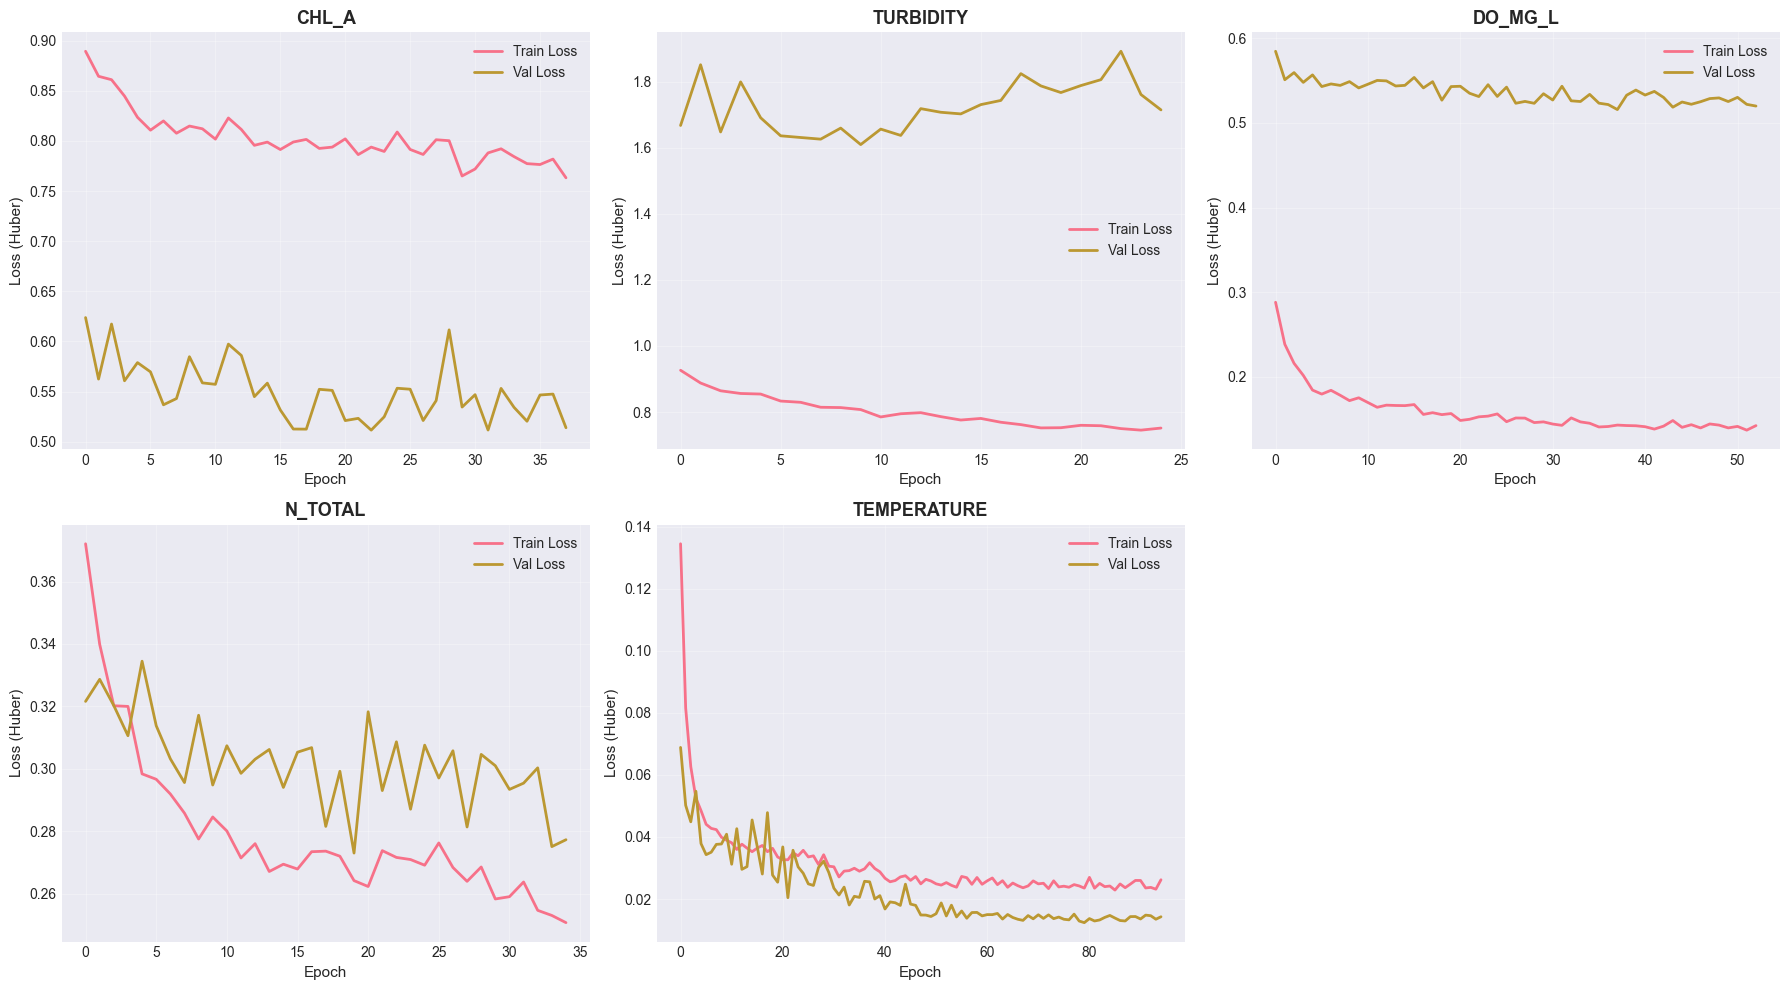

In [22]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    history = histories[param]
    axes[idx].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[idx].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('Loss (Huber)', fontsize=11)
    axes[idx].set_title(f'{param.upper()}', fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 11. Evaluate All Models on Test Set

In [23]:
def evaluate_model(model, data_dict, param_name):
    """
    Evaluate model on test set and return metrics + predictions.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    X_test_tensor = torch.FloatTensor(data_dict['X_test']).to(device)
    
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).cpu().numpy()
    
    # Inverse transform predictions
    y_pred = data_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = data_dict['y_test_original']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'y_true': y_true,
        'y_pred': y_pred,
    }

# Evaluate all models
results = {}
for param in TARGET_PARAMS:
    results[param] = evaluate_model(models[param], param_data[param], param)

print("✓ All models evaluated")

✓ All models evaluated


In [24]:
# Print results
print("\n" + "="*80)
print("EVALUATION RESULTS - EXTERNAL MODEL (Test Set)")
print("="*80)

for param in TARGET_PARAMS:
    res = results[param]
    print(f"\n{param.upper()}:")
    print(f"  RMSE: {res['rmse']:10.4f}")
    print(f"  MAE:  {res['mae']:10.4f}")
    print(f"  R²:   {res['r2']:10.4f}")
    print(f"  MAPE: {res['mape']:10.2f}%")

# Calculate overall metrics
avg_r2 = np.mean([results[p]['r2'] for p in TARGET_PARAMS])
avg_rmse = np.mean([results[p]['rmse'] for p in TARGET_PARAMS])
avg_mae = np.mean([results[p]['mae'] for p in TARGET_PARAMS])

print("\n" + "="*80)
print("AVERAGE ACROSS ALL PARAMETERS:")
print(f"  Avg RMSE: {avg_rmse:.4f}")
print(f"  Avg MAE:  {avg_mae:.4f}")
print(f"  Avg R²:   {avg_r2:.4f}")
print("="*80)


EVALUATION RESULTS - EXTERNAL MODEL (Test Set)

CHL_A:
  RMSE:     6.7765
  MAE:      3.1359
  R²:       0.1346
  MAPE:     158.39%

TURBIDITY:
  RMSE:     9.8546
  MAE:      3.9579
  R²:       0.0415
  MAPE:     183.72%

DO_MG_L:
  RMSE:    12.1571
  MAE:      1.6537
  R²:      -0.0097
  MAPE:       7.72%

N_TOTAL:
  RMSE:   695.2164
  MAE:    249.9227
  R²:       0.0227
  MAPE:      31.31%

TEMPERATURE:
  RMSE:     1.4218
  MAE:      1.0591
  R²:       0.8851
  MAPE:       6.79%

AVERAGE ACROSS ALL PARAMETERS:
  Avg RMSE: 145.0853
  Avg MAE:  51.9459
  Avg R²:   0.2148


## 12. Visualize Predictions vs Actual

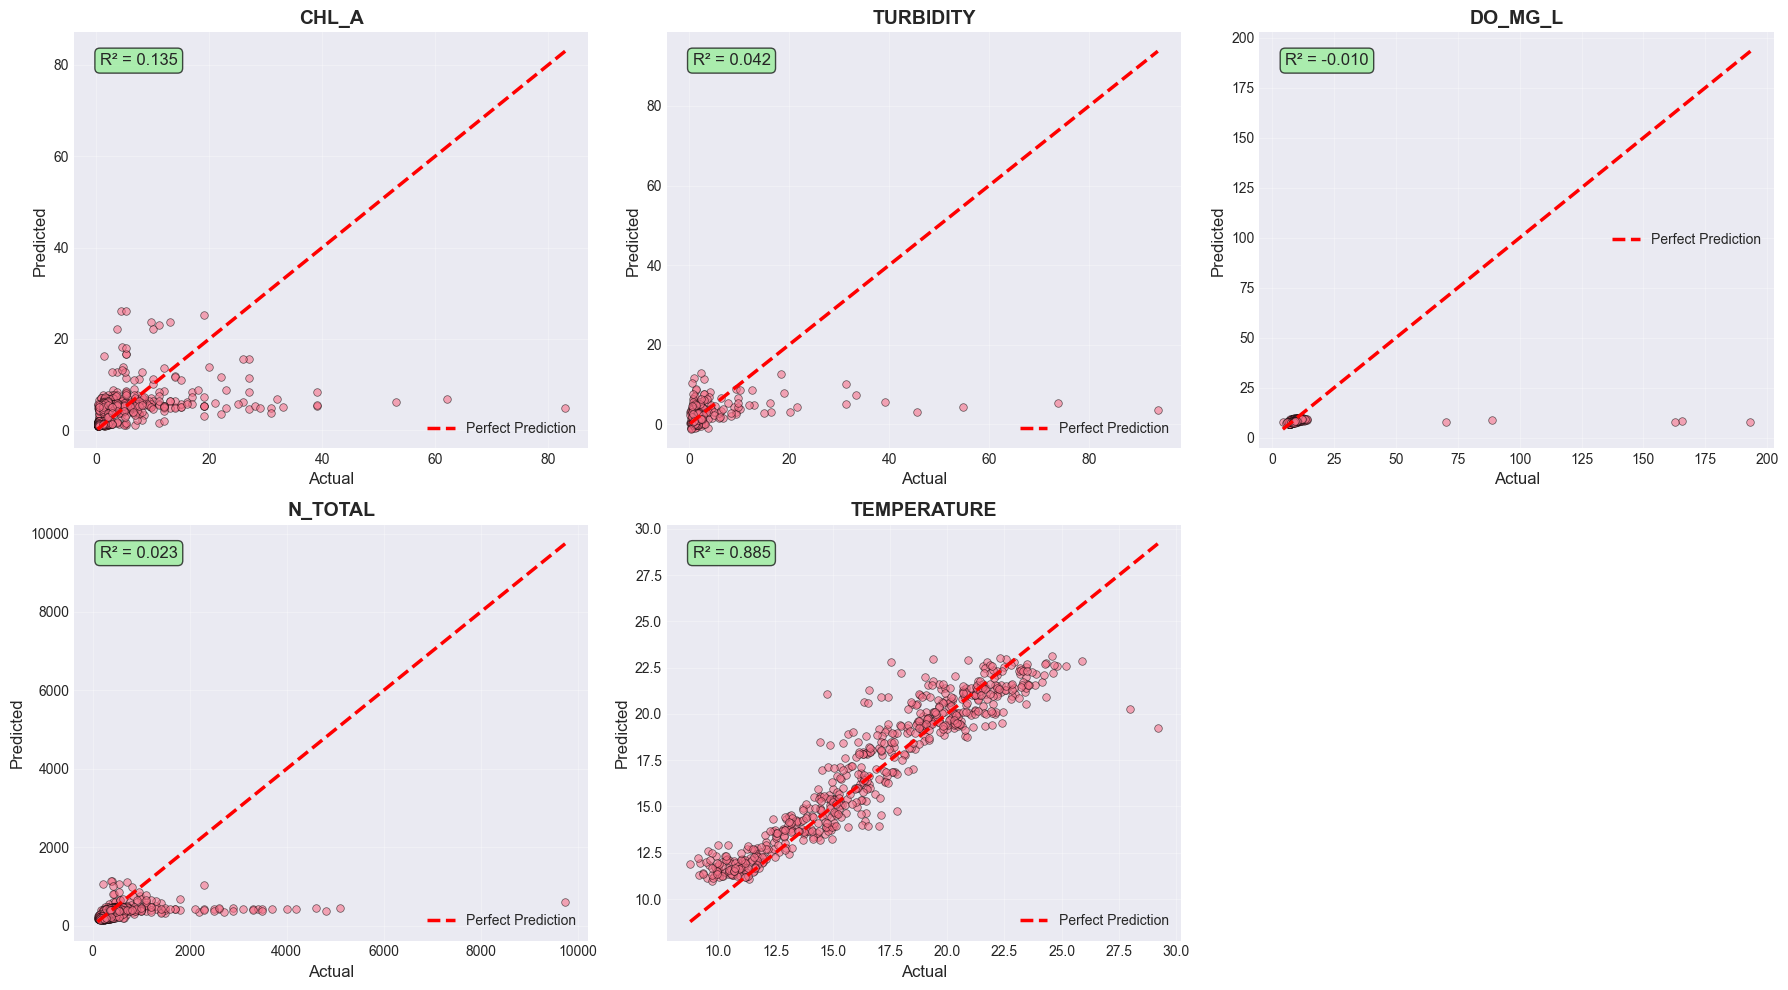

In [25]:
# Prediction scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    res = results[param]
    y_true = res['y_true']
    y_pred = res['y_pred']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', linewidth=2.5, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual', fontsize=12)
    axes[idx].set_ylabel('Predicted', fontsize=12)
    axes[idx].set_title(f'{param.upper()}', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add R² annotation
    r2 = res['r2']
    axes[idx].text(0.05, 0.95, f"R² = {r2:.3f}", 
                  transform=axes[idx].transAxes, 
                  fontsize=12, 
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 13. Save All Models

In [26]:
import pickle

# Create directory if it doesn't exist
os.makedirs('../model/external/v1', exist_ok=True)

# Save each model with its artifacts
for param in TARGET_PARAMS:
    model_artifact = {
        'model_state_dict': models[param].state_dict(),
        'model_architecture': {
            'input_dim': INPUT_DIM,
            'hidden_dims': [128, 64],
            'dropout': 0.4,
        },
        'scaler_X': param_data[param]['scaler_X'],
        'scaler_y': param_data[param]['scaler_y'],
        'features': ALL_FEATURES,
        'training_history': histories[param],
        'test_metrics': results[param],
    }
    
    torch.save(model_artifact, f'../model/external/v1/{param}_model.pth')
    print(f"✓ Saved: ../model/external/v1/{param}_model.pth")

# Save encoders and imputers
with open('../model/external/v1/encoders.pkl', 'wb') as f:
    pickle.dump({
        'site_encoder': site_encoder,
        'water_body_encoder': water_body_encoder,
    }, f)

print("\n✓ All models and encoders saved!")

✓ Saved: ../model/external/v1/chl_a_model.pth
✓ Saved: ../model/external/v1/turbidity_model.pth
✓ Saved: ../model/external/v1/do_mg_l_model.pth
✓ Saved: ../model/external/v1/n_total_model.pth
✓ Saved: ../model/external/v1/temperature_model.pth

✓ All models and encoders saved!


## 14. Summary

Compare external model performance with internal model.

In [27]:
print("\n" + "="*80)
print("SUMMARY - EXTERNAL MODEL (Open Meteo Features Only)")
print("="*80)

print("\n📊 MODEL PERFORMANCE:")
for param in TARGET_PARAMS:
    r2 = results[param]['r2']
    symbol = "✓" if r2 > 0.3 else "⚠️" if r2 > 0 else "✗"
    print(f"  {symbol} {param.upper():15} - R²: {r2:7.4f} | RMSE: {results[param]['rmse']:10.4f} | MAE: {results[param]['mae']:9.4f}")

print(f"\n  Average R²:   {avg_r2:.4f}")
print(f"  Average RMSE: {avg_rmse:.4f}")
print(f"  Average MAE:  {avg_mae:.4f}")

print("\n📈 DATASET STATISTICS:")
print(f"  Total merged records: {len(df)}")
print(f"  Sites: {df['site_id'].nunique()}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Total features used: {INPUT_DIM}")
print(f"    - Open Meteo: {len(om_feature_cols)}")
print(f"    - Site: {len(site_features)}")
print(f"    - Temporal: {len(temporal_features)}")
print(f"    - Lag: {len(lag_features)}")

print("\n🎯 KEY FINDINGS:")
print("  - External features (weather/marine/flood) used to predict water quality")
print("  - No EPA historical water quality data used as features")
print("  - Models show varying performance across parameters")
print("  - Next step: Build hybrid model combining internal + external features")

print("\n" + "="*80)


SUMMARY - EXTERNAL MODEL (Open Meteo Features Only)

📊 MODEL PERFORMANCE:
  ⚠️ CHL_A           - R²:  0.1346 | RMSE:     6.7765 | MAE:    3.1359
  ⚠️ TURBIDITY       - R²:  0.0415 | RMSE:     9.8546 | MAE:    3.9579
  ✗ DO_MG_L         - R²: -0.0097 | RMSE:    12.1571 | MAE:    1.6537
  ⚠️ N_TOTAL         - R²:  0.0227 | RMSE:   695.2164 | MAE:  249.9227
  ✓ TEMPERATURE     - R²:  0.8851 | RMSE:     1.4218 | MAE:    1.0591

  Average R²:   0.2148
  Average RMSE: 145.0853
  Average MAE:  51.9459

📈 DATASET STATISTICS:
  Total merged records: 4492
  Sites: 21
  Date range: 1984-07-19 to 2025-06-20
  Total features used: 68
    - Open Meteo: 52
    - Site: 4
    - Temporal: 7
    - Lag: 5

🎯 KEY FINDINGS:
  - External features (weather/marine/flood) used to predict water quality
  - No EPA historical water quality data used as features
  - Models show varying performance across parameters
  - Next step: Build hybrid model combining internal + external features

